# Synthetic RNA Structure Prediction Pipeline

This notebook shows how to train and evaluate a simple model with *synthetic
data*, which imitate real RNA structures but do not represent actual molecules.


## Requirements to Execute this Notebook

- A Python virtual environment installed as described in the `readme.rst` file
  of the project.


## Presentation

Why would anyone use fake data while real ones are available?

- **Size**: You have control over the size of the synthetic structures. RNA
  molecules can be a few hundreds of bases long, so processing them requires
  large resources. When prototyping a model, you don't necessarily need large
  molecules, so creating small ones that accelerate this process.
- **Validate a model**: You can use synthetic data to check that your model
  converges to a solution before trying with real data.
- **Easier visualization**: Since synthetic structures are smaller, they make
  it easier to visualize and understand the pipeline.

In [1]:
# Required imports.
from random import randint

from torch import nn, optim, stack, squeeze, Tensor, tensor
import torch.nn.functional as F

from diurnal import train, structure, visualize, evaluate, transform
import diurnal.models.deep
from diurnal.utils import synthetic

## Create a Synthetic Dataset

The first step consists in creating primary and secondary structures.

In [2]:
N = 2000  # Number of structures. May contain duplicates.
n_min = 10  # Minimum length of a structure.
n_max = 32  # Maximum length of a structure.

primary = []
secondary = []

for _ in range(N):
    p, s = synthetic.make_structures(randint(n_min, n_max))
    primary.append(p)
    secondary.append(s)

In [3]:
# Check the structures
index = 2
print(f"Primary structure at index {index}: {primary[index]}")
print(f"Secondary structure at index {index}: {secondary[index]}")
bracket = structure.Secondary.to_bracket(secondary[index])
print(f"Secondary structure in brackets at index {index}: {bracket}")
contact = structure.Secondary.to_matrix(secondary[index])
print(f"Secondary structure contact matrix at index {index}:\n{contact}")

Primary structure at index 2: UGCCCAUACAGCGCGUU
Secondary structure at index 2: [-1, 13, -1, 12, 10, -1, -1, -1, -1, -1, 4, -1, 3, 1, -1, -1, -1]
Secondary structure in brackets at index 2: ['.', '(', '.', '(', '(', '.', '.', '.', '.', '.', ')', '.', ')', ')', '.', '.', '.']
Secondary structure contact matrix at index 2:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 

The function `synthetic.make_structures` creates a primary and a secondary
structure. The base pairings of the secondary structure are `A-U`, `C-G` and
`G-U` (wobble pair). You can also visualize that in a graph with the function
`visualize.pairings`, which combines the pairing and contact matrices.

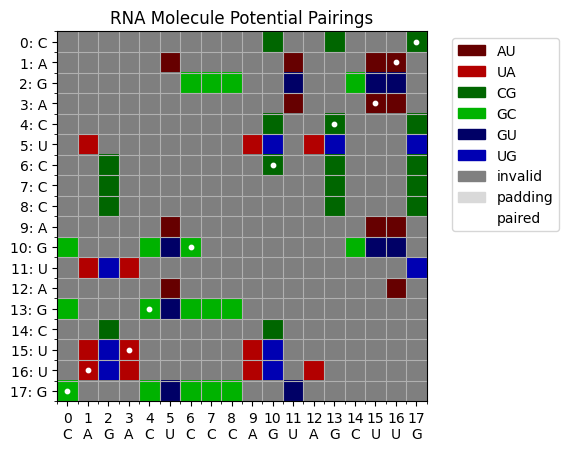

In [4]:
index = 1
visualize.potential_pairings(
    primary[index],
    secondary = secondary[index]
)

As listed in the legend, the colored squares indicate potential pairings (i.e.
bases that can pair) while gray squares indicate pairings that are physically
impossible. The white dots indicate the secondary structure (i.e. the bases
that are actually paired). Notice that no white dot is located on a gray square.

## Prepare Data for Training

We have generated synthetic structures, but we now have to (1) split them into
distinct sets and (2) format the structures into matrix formats for training.

### Split Data

The function `diurnal.train.split` divides a list of structures into lists of
non-overlapping elements. We use `x` to denote the input data (i.e. the primary
structure) and `y` to denote the output data (i.e. the secondary structure).

The function **does not** shuffle data before splitting them, so ensure that
your dataset is homogeneous *before* calling it.

In [5]:
train_x, validation_x, test_x = train.split(primary, (0.8, 0.1, 0.1))
train_y, validation_y, test_y = train.split(secondary, (0.8, 0.1, 0.1))

### Format the Data

Neural networks manipulate matrices of numbers, so we need to transform our
original data.

In this example, we will use the matrix of potential pairings as the input. Each
pairing is represented as a scalar, with `CG = 3`, `AU = 2`, and `GU = 1`.
Unpaired bases are represented as `0` and padding elements, with `-1`. We
use the *distance matrix* as the output, which is a blurred contact matrix.

Neural networks take as inputs matrices of the same dimension. Therefore, we
define `SIZE = 32` as the normalized dimension of the data.

In [6]:
SIZE = 32
train_x = [structure.Primary.to_matrix(
        x, SIZE, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    ) for x in train_x]
validation_x = [structure.Primary.to_matrix(
        x, SIZE, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    ) for x in validation_x]
test_x = [structure.Primary.to_matrix(
        x, SIZE, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    ) for x in test_x]

POWER = 5
train_y = [
    structure.Secondary.to_distance_matrix(y, SIZE, power = POWER) for y in train_y
]
validation_y = [
    structure.Secondary.to_distance_matrix(y, SIZE, power = POWER) for y in validation_y
]
test_y = [
    structure.Secondary.to_distance_matrix(y, SIZE, power = POWER) for y in test_y
]

Let's visualize our input data before going farther:

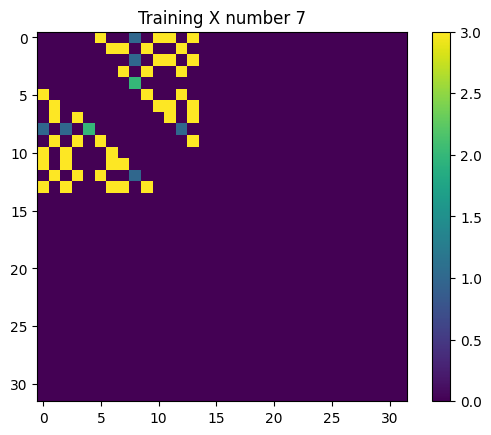

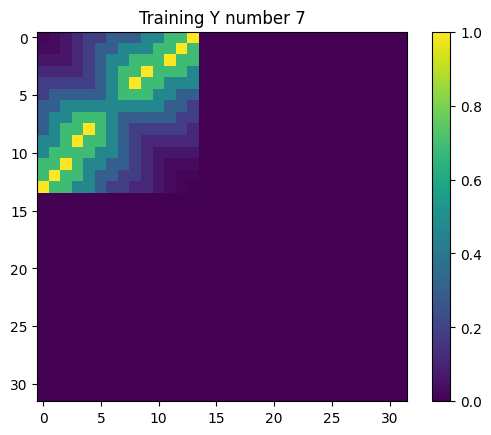

In [7]:
index = 7
visualize.heatmap(train_x[index], f"Training X number {index}")
visualize.heatmap(train_y[index], f"Training Y number {index}")

Notice that padding was added to the matrices to normalize their size to 32.

We will now place data into dictionaries. The package `diurnal.models.deep`
expects dictionaries of a certain format to simplify training. It contains the
following keys:

- `input`: The input data provided to the model. There can be more than one, so
  the input is formatted as a tuple.
- `output`: The output data used by the model to perform backpropagation. The
  models produce one output, so this field is not formatted as a dictionary.
- `names`: The names of the RNA molecules. These names will be included in the
  saved model. We can leave it empty because we use synthetic data.

In [8]:
train_set = {
    "input": (train_x, ),
    "output": train_y,
    "names": []
}
validation_set = {
    "input": (validation_x, ),
    "output": validation_y,
    "names": []
}
test_set = {
    "input": (test_x, ),
    "output": test_y,
    "names": []
}

## Create a Model

We'll use PyTorch to create a neural network that produces a distance matrix
from a potential pairing matrix.

In [9]:
class SyntheticDistancePredictor(nn.Module):
    """This model outputs a distance matrix from a potential pairing
    matrix.

    Args:
        n (int): Length of the input structures.
    """
    def __init__(self, n: int):
        super().__init__()
        kernel = 3
        n_half = int(n / 2)
        self.conv1 = nn.Conv2d(1, 1, kernel, padding="same")
        self.downsize = nn.AdaptiveAvgPool2d(n_half)
        self.activation = F.relu
        self.linear1 = nn.Linear(n_half, n_half)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.linear2 = nn.Linear(n, n)
        self.linear3 = nn.Linear(n, n)
        self.output = nn.Sigmoid()

    def forward(self, input: Tensor) -> Tensor:
        """Forward propagation.

        Args:
            input: Potential pairing matrix.

        Returns: Distance matrix.
        """
        input = stack((input, ), dim=1)
        input = self.conv1(input)
        input = self.activation(input)
        input = self.downsize(input)
        input = self.activation(input)
        input = self.linear1(input)
        input = self.upsample(input)
        input = self.linear2(input)
        input = self.activation(input)
        input = self.linear3(input)
        input = self.output(input)
        input = squeeze(input)
        return input

## Train the Model

The class `diurnal.models.deep.NN` wraps PyTorch operations to train a model.
We just provided the parameters and train the model.

In [13]:
from diurnal.models.deep import cnn

class UNet2D(nn.Module):
    """U-net neural network with linear layers.

    Input: 2D array.

    Output: 2D array with elements comprised within the range (0, 1).
    """
    def __init__(
            self,
            n: int,
            depth: int,
            kernel: int = 3,
            downsizer=nn.AdaptiveAvgPool2d,
            upsizer = nn.Upsample
        ):
        super().__init__()
        # Parameters.
        self.n = n
        self.depth = depth
        self.kernel = kernel
        # Network components.
        self.activation = F.relu
        self.conv1 = nn.Conv2d(1, 1, self.kernel, padding="same")
        self.downsizers = []
        self.upsizers = []
        self.down_full_layers = []
        self.up_full_layers = []
        for _ in range(depth):
            self.down_full_layers.append(nn.Linear(n, n))
            self.up_full_layers.append(nn.Linear(n, n))
            n = int(n / 2)
            self.downsizers.append(downsizer(n))
            self.upsizers.append(upsizer(
                scale_factor=2, mode='bilinear'
            ))
        self.bottom = nn.Linear(n, n)
        self.down_full_layers = nn.Sequential(*self.down_full_layers)
        self.up_full_layers = nn.Sequential(*self.up_full_layers)
        self.output = nn.Sigmoid()

    def forward(self, x: Tensor) -> Tensor:
        # Input processing.
        x = stack((x, ), dim=1)
        x = self.conv1(x)
        reserve = []
        # Downsizing.
        for i in range(self.depth):
            x = self.down_full_layers[i](x)
            reserve.append(x.clone())
            x = self.downsizers[i](x)
            x = self.activation(x)
        # Lowest layer.
        x = self.bottom(x)
        x = self.activation(x)
        # Upsizing.
        for i in range(self.depth - 1, -1, -1):
            x = self.upsizers[i](x)
            x = self.up_full_layers[i](x)
            x *= reserve[i]
            x = self.activation(x)
        x = self.output(x)
        x = squeeze(x)
        return x

N_MAX_EPOCHS = 500
model = diurnal.models.deep.NN(
    model=UNet2D(SIZE, 3),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=10,
    verbosity=2,
)
model.train(train_set, validation_set)

2024-06-02T19:42:41.664836 > INFO Training the model with 1600 data points.
2024-06-02T19:42:41.666065 >     Using 200 data points for validation.
2024-06-02T19:42:41.667073 >     Beginning the training.
2024-06-02T19:42:42.347335 >   0 / 500 [                                                  ] Loss: 0.17225  Patience: 10
2024-06-02T19:42:42.910672 >   1 / 500 [                                                  ] Loss: 0.17225  Patience: 10
2024-06-02T19:42:43.486811 >   2 / 500 [                                                  ] Loss: 0.17225  Patience: 9
2024-06-02T19:42:44.075871 >   3 / 500 [                                                  ] Loss: 0.17225  Patience: 8
2024-06-02T19:42:44.642739 >   4 / 500 [                                                  ] Loss: 0.17224  Patience: 8
2024-06-02T19:42:45.251884 >   5 / 500 [                                                  ] Loss: 0.17223  Patience: 8
2024-06-02T19:42:45.770227 >   6 / 500 [                                        

In [11]:
N_MAX_EPOCHS = 500
model = diurnal.models.deep.NN(
    model=SyntheticDistancePredictor(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(train_set, validation_set)

NameError: name 'r' is not defined

## Predict Structures

Now that the model is trained, we can use forward propagation to predict
secondary structures.

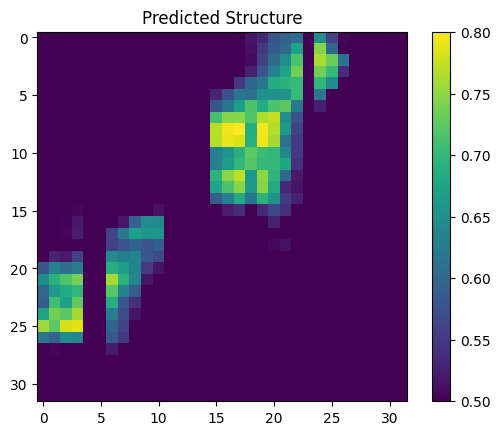

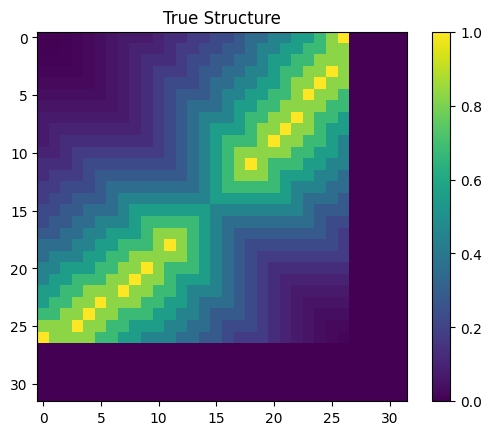

In [14]:
index = 3
prediction = model.predict((test_x[index], ))
true_structure = test_y[index]
visualize.heatmap(prediction, "Predicted Structure")
visualize.heatmap(true_structure, "True Structure")

The neural network produces "fuzzy" outputs tht range from 0 to 1. A contact
matrix comprises *binary* elements, which are either 0 (unpaired) or 1 (paired).
You can convert the output of the model in a contact matrix with the function
`train.quantize_matrix(pred)`.

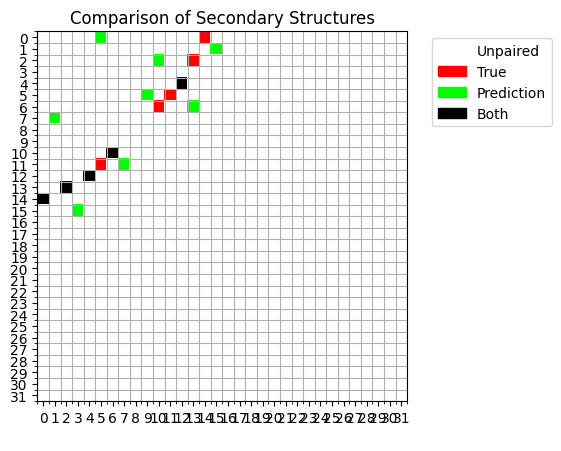

F1-score: 0.4347826086956522


In [18]:
index = 4
prediction = model.predict((test_x[index], ))
mask = test_x[index].copy()
mask[mask <= 0] = 0
mask[mask >= 1] = 1
prediction *= mask
prediction = transform.to_monomial_matrix(prediction)
prediction = transform.to_binary_matrix(prediction)
true_structure = structure.Secondary.quantize_distance_matrix(test_y[index])

# Exclude padding
length = len(structure.Primary.unpad_matrix(test_x[index], {"-": -1}))
prediction = evaluate.ContactMatrix.crop(prediction, length)
true_structure = evaluate.ContactMatrix.crop(true_structure, length)

visualize.compare_pairings(true_structure, prediction)
print(f"F1-score: {evaluate.ContactMatrix.f1(true_structure, prediction)}")

## Data Transformation

The module `diurnal.transform` contains functions that can transform RNA
structure representations into other formats.

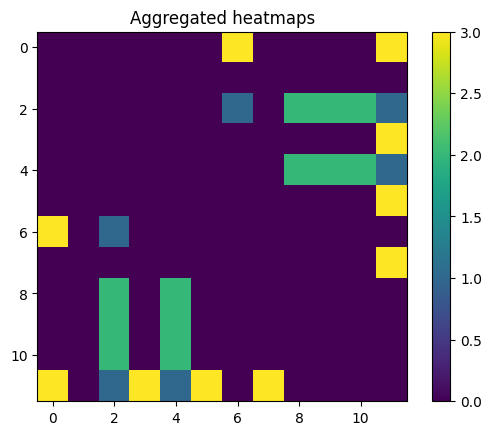

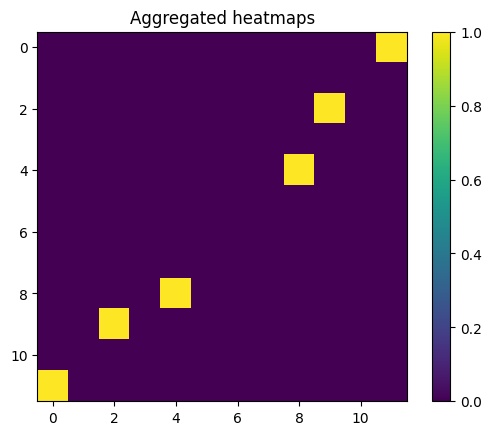

In [ ]:
p, s = synthetic.make_structures(12)
potential_pairings = structure.Primary.to_matrix(p, map=structure.Schemes.IUPAC_PAIRINGS_SCALARS)
contact = structure.Secondary.to_matrix(s)

visualize.heatmap(potential_pairings)
visualize.heatmap(contact)

Potential pairing and contact matrices are redundant because the information
in the lower half of the matrix mirrors the information in the upper half. The
function `transform.halve_matrix` sets the elements in the upper matrix to `0`
to decrease redundance.

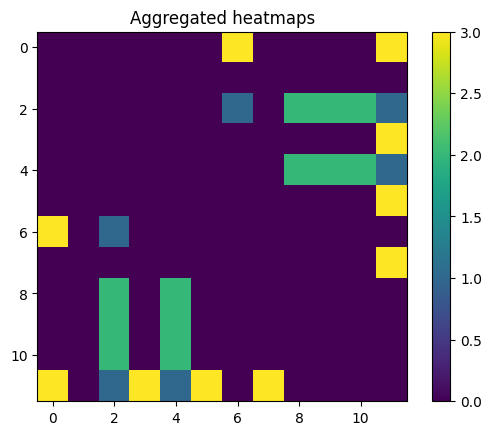

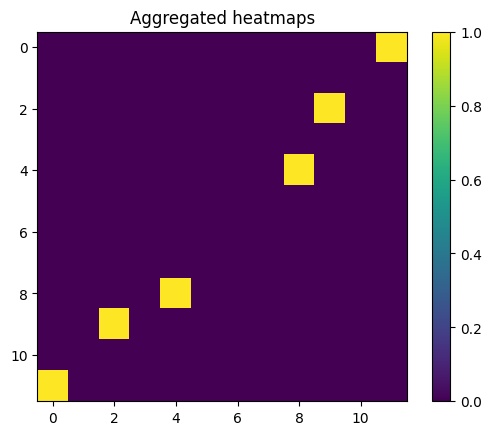

In [ ]:
transform.halve_matrix(potential_pairings)
transform.halve_matrix(contact)

visualize.heatmap(potential_pairings)
visualize.heatmap(contact)

In [ ]:
potential_pairings = transform.linearize_half_matrix(potential_pairings)
contact = transform.linearize_half_matrix(contact)
N = len(contact)

print(potential_pairings)
print(contact)
original_length = len(potential_pairings)

[0 0 0 0 3 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 3 0 2 0 0 0 2 0 2 1 0 2 0 3 2 0 1
 0 0 3 0 0 0 3 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


In [ ]:
potential_pairings = transform.collapse_linearized_matrix(potential_pairings)
contact = transform.collapse_like(potential_pairings, contact)

print(potential_pairings)
print(contact)

[-4.  3. -6.  1. -6.  2. -1.  3. -1.  2. -3.  2. -1.  2.  1. -1.  2. -1.
  3.  2. -1.  1. -2.  3. -3.  3. -1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [ ]:
contact = transform.decollapse_like(potential_pairings, contact, N)
potential_pairings = transform.decollapse_linearized_matrix(
    potential_pairings, N_output=original_length
)

print(potential_pairings)
print(contact)

[0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 2. 0. 3. 0. 2. 0.
 0. 0. 2. 0. 2. 1. 0. 2. 0. 3. 2. 0. 1. 0. 0. 3. 0. 0. 0. 3. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


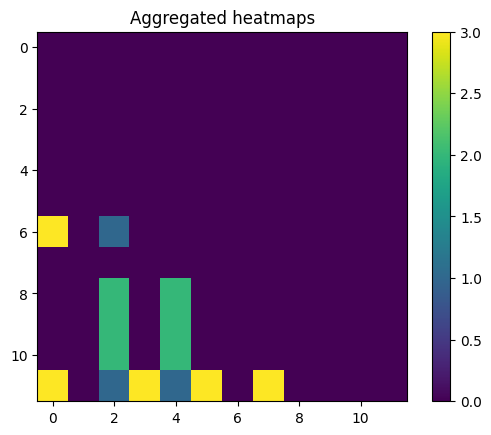

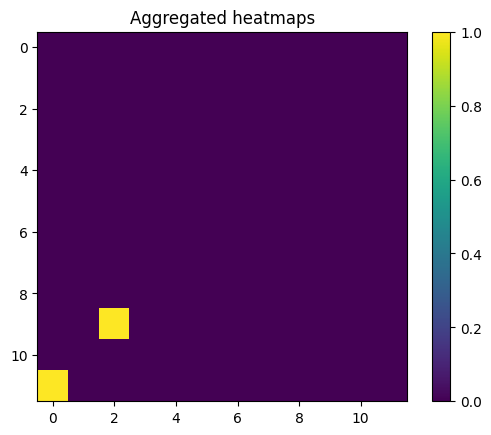

In [ ]:
potential_pairings = transform.delinearize_half_matrix(potential_pairings, 12)
contact = transform.delinearize_half_matrix(contact, 12)

visualize.heatmap(potential_pairings)
visualize.heatmap(contact)